In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hepmc import *
from scipy import stats

# Plots
This notebook contains combined plots to highlight the behavior of the Monte Carlo Methods. It uses some of the same plotting routines as are used in the Monte Carlo Intodruction.

In [2]:
from plotting import *

In [3]:
# The same test functions as used in the introduction

# periodic sin in 1 dimension
sin_1d = lambda x: np.sin(2*np.pi*x)
# periodic sin in any dimension; true integral value is 0
sin_nd = lambda *x: np.prod([sin_1d(xi) for xi in x], axis=0)

sqrtx_inv = lambda *x: np.sqrt(1/np.prod(x, axis=0))
sqrtx_inv_trueval = lambda dim: 2**dim  # true integral value depends on dimension

# A more complicated test function
tf_a = 16
tf_b = 1/.2**2
def osc(x):
    return x**2*np.cos(tf_a*np.pi*x/.2)**2*tf_b
def bound(a, x, b):
    return (x>a)*(x<=b)
def test_function(x):
    return bound(.2, x, .4)*osc(x-.2) + bound(.4, x, .6) + bound(.6, x, .8)*osc(.8-x)
test_function_true_value = 2*.0333531 + .2

# corresponding channels
p1 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*32 + bound(.4,x,.6)*2 + bound(.6,x,.8)*32 + bound(.8,x,1)*2)/70/.2
p2 = lambda x: (bound(0,x,.2)*2 + bound(.2,x,.4)*22 + bound(.4,x,.6)*22 + bound(.6,x,.8)*22 + bound(.8,x,1)*2)/70/.2
p3 = lambda x: (bound(.2,x,.4)*((x-.2)/.2)**2 + bound(.6,x,.8)*((.8-x)/.2)**2 + bound(.4,x,.6))/(.2 + .1333333)
sampling1 = AcceptRejectSampler(p1, 3).sample
sampling2 = AcceptRejectSampler(p2, 2).sample
sampling3 = AcceptRejectSampler(p3, 3.5).sample

dist1 = Distribution.make(p1, ndim=1, rvs=lambda count: sampling1(count).data)
dist2 = Distribution.make(p2, ndim=1, rvs=lambda count: sampling2(count).data)
dist3 = Distribution.make(p3, ndim=1, rvs=lambda count: sampling3(count).data)

## Plotting the plain Monte Carlo estimates
This plot shows the distributions of plain Monte Carlo integration of a square integrable and a not square integrable function.

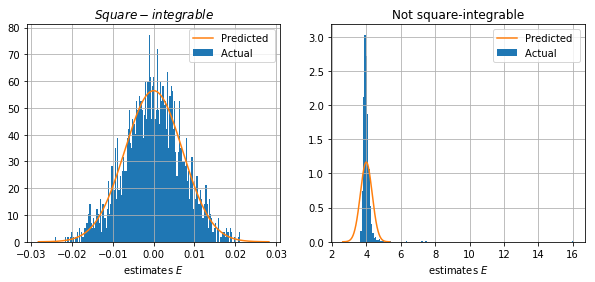

(0.8836252380609854, 0.7436578745640948, 70) (131.45203148663472, 2.8114185969791977e-276, 11)


In [5]:
# Plot errors for sine and 1/sqrt(x) in any dimension
dim = 2
it = 2000  # number of iterations for the histogram
bins = 160  # number of bins for the histograms
N = 5000   # number of function evaluations

plt.figure(figsize=(10,4))
plt.tight_layout()
plt.subplot(121)
plt.title(r"$Square-integrable$")
chi2_1 = plot_distribution(sin_nd, 0, N=N, iterations=it, method=PlainMC(dim), bins=bins)
plt.xlabel("estimates $E$")

plt.subplot(122)
plt.title(r"Not square-integrable")
chi2_2 = plot_distribution(sqrtx_inv, sqrtx_inv_trueval(dim), N=N, iterations=it, method=PlainMC(dim), bins=bins)
plt.xlabel("estimates $E$")
plt.show()

print(chi2_1, chi2_2)

## Plotting the deviations of importance sampling
The integrand is the same test function as before, the deviations (and predicted standard deviations) are showin in a log-log plot, using the plot_rms method introduced previously.

data (size),mean,variance,bin-wise chi^2,effective sample size
1000,[-0.04432085],[1.00464112],"1.278, p=0.2008, N=17",[1000.]


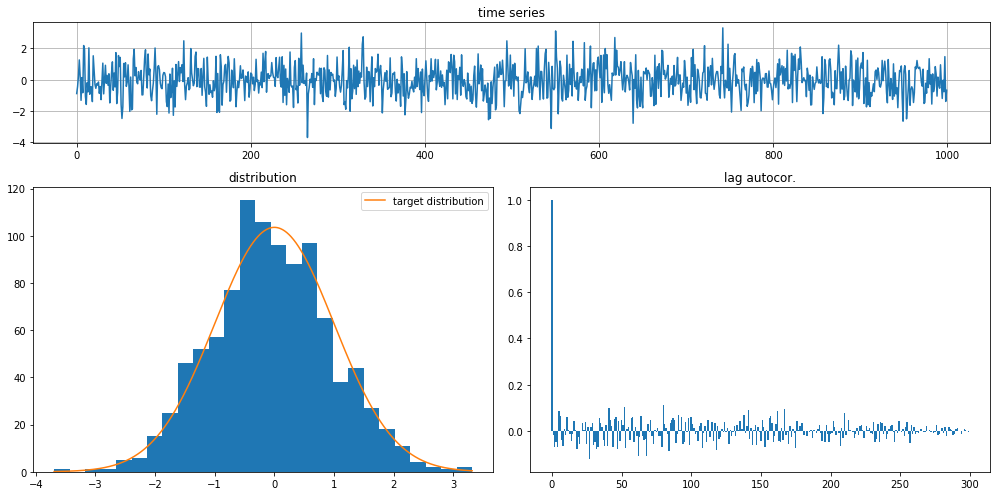

In [13]:
from hepmc.core.sampling import Sample
g = densities.Gaussian(1)
Sample(data=g.rvs(1000), target=g)

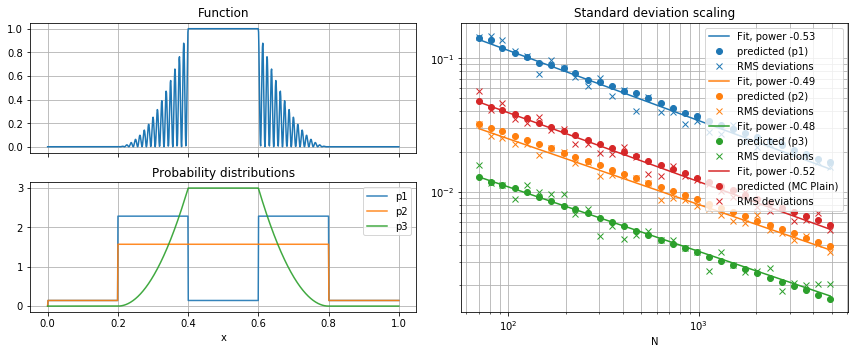

In [14]:
# compare importance sampling to the stratified boxing from before
plt.figure(figsize=(12,5))
ax = plt.subplot2grid((2, 2), (0, 0))
plt.title("Function")
x = np.linspace(0,1,1000)
plt.plot(x,test_function(x))
ax.tick_params(labelbottom='off') 
plt.grid()

plt.subplot2grid((2, 2), (1, 0))
plt.title("Probability distributions")
plt.plot(x, p1(x), label="p1", alpha=.9)
plt.plot(x, p2(x), label="p2", alpha=.9)
plt.plot(x, p3(x), label="p3", alpha=.9)
plt.legend()
plt.xlabel("x")
plt.grid()

plt.subplot2grid((2, 2), (0, 1), rowspan=2)
plt.title("Standard deviation scaling")
Ns = np.logspace(np.log10(70), 2*np.log10(70), 30, dtype=np.int)
plot_rms(test_function, test_function_true_value, iterations=40, Ns=Ns, 
         methods=[ImportanceMC(dist1, name="p1"),
                  ImportanceMC(dist2, name="p2"),
                  ImportanceMC(dist3, name="p3"),
                  PlainMC()], plot_fit=True)
plt.tight_layout(True)
plt.show()

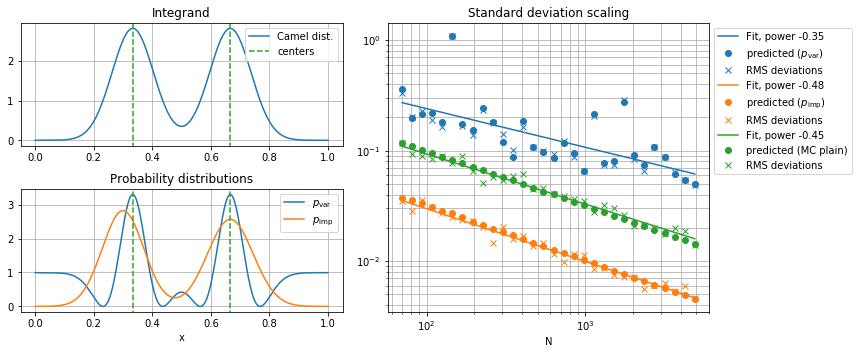

In [145]:
camel = densities.Camel(1)
var_fn = lambda x: (camel.pdf(x) - 1)**2
var_norm = PlainMC()(var_fn, 200000).integral
grad_fn = lambda x: np.abs(camel.pdf_gradient(x).flatten())
grad_norm = PlainMC()(grad_fn, 20000).integral
c1 = Distribution.make(lambda x: var_fn(x)/var_norm, 1, rvs=lambda n: AcceptRejectSampler(var_fn, 3.5).sample(n).data)
c2 = MultiChannel([
        densities.Gaussian(1, mu=1/3*.9, cov=.1**2/2),
        densities.Gaussian(1, mu=2/3, cov=.1**2/2*1.1**2)])
c3 = Distribution.make(lambda x: grad_fn(x)/grad_norm, 1, rvs=lambda n: AcceptRejectSampler(grad_fn, 3.5).sample(n).data)

# compare importance sampling to the stratified boxing from before
plt.figure(figsize=(12,5))
ax = plt.subplot2grid((2, 2), (0, 0))
plt.title("Integrand")
x = np.linspace(0,1,1000)
plt.plot(x,camel(x), label='Camel dist.')
ymin, ymax = plt.gca().get_ylim()
plt.plot([1/3]*2, [-1, 4], '--', color='C2')
plt.plot([2/3]*2, [-1, 4], '--', color='C2', label='centers')
plt.ylim(ymin, ymax)
plt.legend()
plt.grid()

plt.subplot2grid((2, 2), (1, 0))
plt.title("Probability distributions")
plt.plot(x, c1(x), label=r"$p_{\mathrm{var}}$")
plt.plot(x, c2(x), label=r"$p_{\mathrm{imp}}$")
# plt.plot(x, c3(x), label="$p_3$")
ymin, ymax = plt.gca().get_ylim()
plt.plot([1/3]*2, [-1, 4], '--', color='C2')
plt.plot([2/3]*2, [-1, 4], '--', color='C2')
plt.ylim(ymin, ymax)
plt.legend()
plt.xlabel("x")
plt.grid()

plt.subplot2grid((2, 2), (0, 1), rowspan=2)
plt.title("Standard deviation scaling")
Ns = np.logspace(np.log10(70), 2*np.log10(70), 30, dtype=np.int)
plot_rms(camel, 1.0, iterations=50, Ns=Ns, 
         methods=[ImportanceMC(c1, name=r"$p_{\mathrm{var}}$"),
                  ImportanceMC(c2, name=r"$p_{\mathrm{imp}}$"),
#                   ImportanceMC(c3, name="$p_3$"),
                  PlainMC(name='MC plain')], plot_fit=True)

plt.gca().legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout(True, rect=(0, 0, .84, 1))
plt.savefig('../samples_analysis/img2/mc_importance_stddev.pdf')
plt.show()

In [115]:
camel.pdf_gradient([1, 2])

array([[0.],
       [0.]])

## Plot the behavior of the deviatinos of multi-channel Monte Carlo
The deviations do not lie on a line in the log-log plot because the prefactor in the scaling is reduced.
Only in the limit is the scaling like $\sqrt{1/N}$ again.

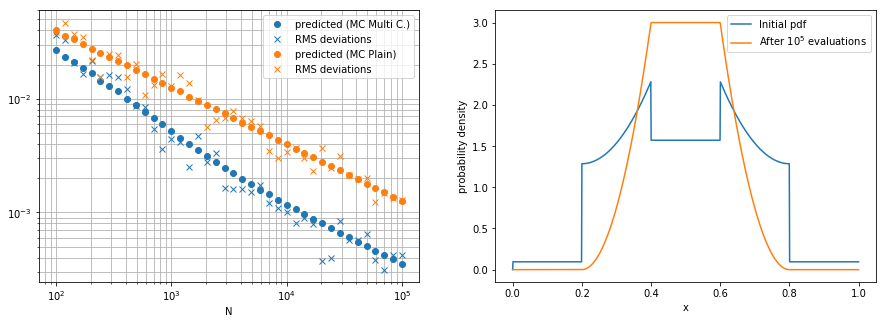

In [17]:
# use on test_function with the three probability distributions from before
channels = MultiChannel([dist1, dist2, dist3])

mcmci = MultiChannelMC(channels).get_interface_ratios(sub_eval_count=100, r1=0, r2=1, r3=0)

plt.figure(figsize=(15, 5))
plt.tight_layout()
ax2 = plt.subplot(122)
channels.plot_pdf(label="Initial pdf")

ax1 = plt.subplot(121)
# Ns = np.logspace(1+np.log10(5), 4, 20, dtype=np.int)
Ns = np.logspace(2, 5, 40, dtype=np.int)
plot_rms(test_function, test_function_true_value, Ns=Ns, iterations=10, 
               methods=[mcmci, PlainMC()])
plt.sca(ax2)
channels.plot_pdf(label="After $10^5$ evaluations")
plt.xlabel("x")
plt.ylabel("probability density")
plt.legend(loc=1)

plt.show()

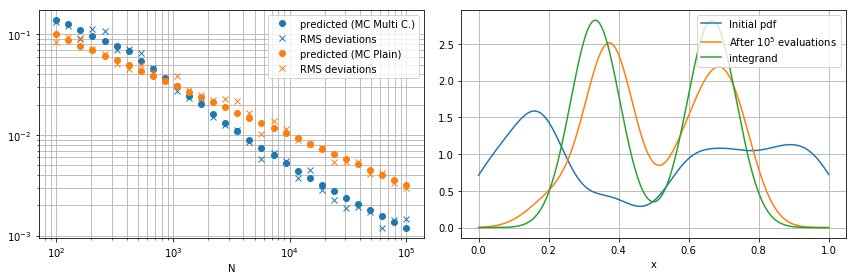

In [148]:
np.random.seed(42)
# use on test_function with the three probability distributions from before
channels = MultiChannel([densities.Gaussian(1, mu=center, cov=0.005) for center in np.random.random(15)])
target = densities.Camel(1)
camel_value = 1.

mcmci = MultiChannelMC(channels).get_interface_ratios(sub_eval_count=400, r1=0, r2=1, r3=0)

plt.figure(figsize=(12, 4))
plt.tight_layout()
ax2 = plt.subplot(122)
channels.plot_pdf(label="Initial pdf")

ax1 = plt.subplot(121)
# Ns = np.logspace(1+np.log10(5), 4, 20, dtype=np.int)
Ns = np.logspace(2, 5, 30, dtype=np.int)
plot_rms(target, camel_value, Ns=Ns, iterations=20, 
               methods=[mcmci, PlainMC()])
plt.sca(ax2)
channels.plot_pdf(label="After $10^5$ evaluations")
plt.plot(np.linspace(0, 1, 1000), target.pdf(np.linspace(0, 1, 1000)), label='integrand')
plt.grid()
plt.xlabel("x")
# plt.ylabel("probability density")
plt.legend(loc=1)
plt.tight_layout()
plt.savefig('../samples_analysis/img2/mc_multi_adapt.pdf')
plt.show()

## Inspecting the statistics of a local Markov Chain random walk
If the proposal distributino in the Metropolis algorithm is very local, a large autocorrelation is introduced.

In [74]:
# example: local proposal and uniform pdf metropolis, proposal area 1/5th as large
bins = 20
delta = .03
count = 1000
np.random.seed(42)
proposal = lambda s: min(max(0, s-delta/2), 1-delta) + np.random.rand()*delta
proposal_pdf = lambda x, y: 1/delta
proposal_generator = Proposal.make(proposal, 1)
gaussian = densities.Gaussian(1, mu=.5, scale=.1)
pdf = gaussian.pdf
metrop_gauss02 = DefaultMetropolis(1, pdf, proposal=proposal_generator)

sample = metrop_gauss02.sample(count, .78)
r = sample.data
print(util.bin_wise_chi2(sample, bins=bins))

plt.figure(figsize=(10, 2))
# plt.title("time series plot")
plt.subplot(131)
plt.plot(r)
plt.xlabel("$k$")
plt.ylabel("$x_k$")
plt.grid()

# plot histogram
plt.subplot(132)
# plt.title("histogram")
plt.hist(r, bins=bins, normed=True, label="sample")
x = np.linspace(0, 1, 1000)
plt.grid()
plt.xlabel("$x$")
plt.plot(x, pdf(x), label="distribution")
plt.legend()

# plot autocorrelation
plt.subplot(133)
# plt.title("autocorrelation")
acor = util.auto_corr(r).flatten()
plt.fill_between(np.arange(len(acor)), acor)
plt.xlabel("lag $k$")
plt.ylabel(r"autocorrelation $\hat{\rho}_k$")
plt.grid()
plt.tight_layout()
plt.show()

(250.144565875991, 0.0, 14)


In [66]:
sample.target = gaussian
sample

data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
1000,[0.51642283],[0.00995208],"6.969, p=1.076e-13, N=14",[5.69927931],0.962000


In [77]:
bins = util.fd_bins(sample)
bins

array([16])

In [70]:
chi2s = []
chi2ps = []
chi2ns = []
for bins in range(5, 500):
    c, p, n = util.bin_wise_chi2(sample, bins=bins, bin_range=[[0, 1]])
    chi2s.append(c)
    chi2ns.append(n)
    chi2ps.append(p)
plt.subplot(121)
plt.plot(chi2s, label=r'$\chi^2$')
plt.plot(chi2ns, label='valid bins')
plt.legend()
plt.grid()
plt.subplot(122)
plt.semilogy(chi2ps)
plt.grid()

/home/mathis/anaconda3/lib/python3.6/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


## MC3 sampling of a modulated sin^2
Two settings of beta illustrate the impact of that parameter on the sample.

Generated 5000 samples.
Generated 10000 samples.
Generated 15000 samples.
Generated 20000 samples.
Generated 25000 samples.
Generated 30000 samples.
6.78415418758736
Generated 5000 samples.
Generated 10000 samples.
Generated 15000 samples.
Generated 20000 samples.
Generated 25000 samples.
Generated 30000 samples.
117.76219539071116


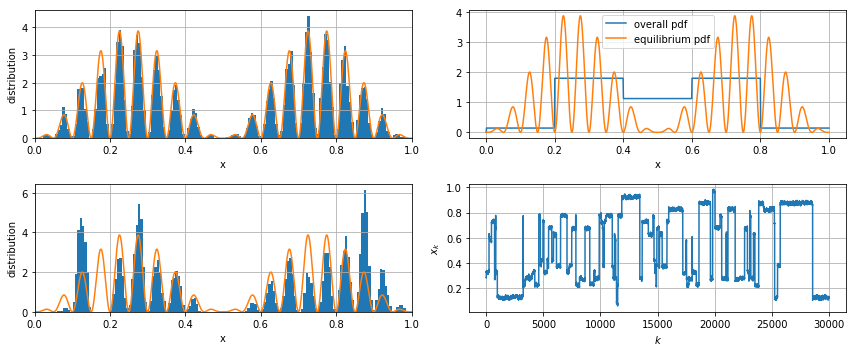

In [27]:
bins = 150

fn = lambda x: np.sin(2*np.pi*x)**2 * np.sin(10*2*np.pi*x)**2
mc3_sampler = mc3.MC3Uniform(fn, MultiChannel([dist1, dist2, dist3]), delta=.01, beta=0.6)
# beta = 1: only importance sampling
res = mc3_sampler(([], [500]*40, []), 30000).data
print(util.binwise_chi2(lambda x: fn(x)/mc3_sampler.integration_sample.integral, res, bins=bins))

plt.figure(figsize=(12,5))
plt.subplot(221)
plt.hist(res, normed=True, bins=bins)
plt.xlim(0, 1)
x = np.linspace(0, 1, 1000)
plt.plot(x, fn(x)/mc3_sampler.integration_sample.integral)
plt.grid()
plt.xlabel("x")
plt.ylabel("distribution")

plt.subplot(222)
mc3_sampler.channels.plot_pdf(label="overall pdf")
plt.plot(x, fn(x)/mc3_sampler.integration_sample.integral, label="equilibrium pdf")
plt.grid()
plt.xlabel("x")
plt.legend()

##### sample using more local updates
mc3_sampler.beta=0.01
res = mc3_sampler.sample(30000).data
# beta = 1: only importance sampling
print(util.binwise_chi2(lambda x: fn(x)/mc3_sampler.integration_sample.integral, res, bins=bins))

plt.subplot(223)
plt.hist(res, normed=True, bins=bins)
plt.xlim(0, 1)
x = np.linspace(0, 1, 1000)
plt.plot(x, fn(x)/mc3_sampler.integration_sample.integral)
plt.grid()
plt.xlabel("x")
plt.ylabel("distribution")

plt.subplot(224)
plt.plot(res)
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$x_k$")
plt.tight_layout()

plt.show()

In [24]:
target = densities.Camel(1)
local = proposals.Gaussian(1, cov=0.005)
sampler = StochasticOptimizeUpdate(target, local, target_rate=0.3, mult=.5, t0=1, kappa=.85)

Generated 5000 samples.
Generated 10000 samples.


data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
10000,[0.49391492],[0.03351244],"4.562, p=1.96e-12, N=24",[4096.60698346],0.306800


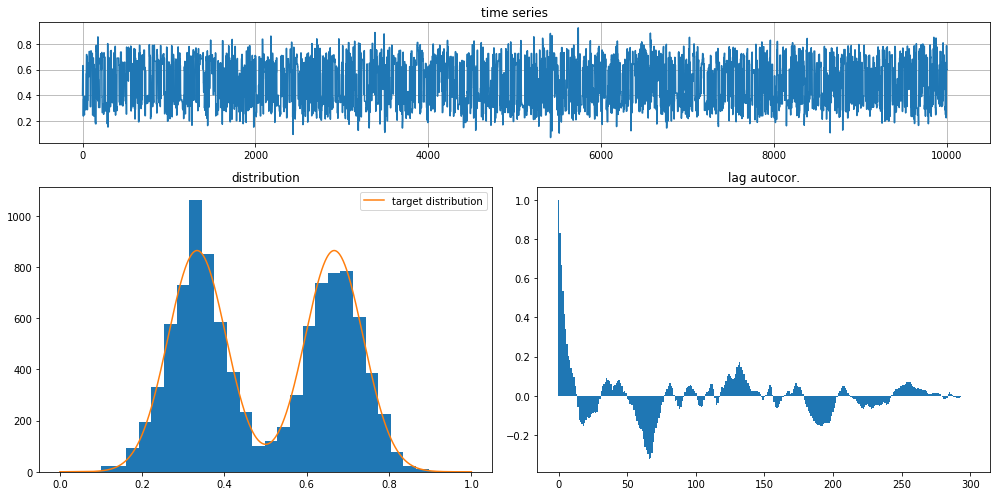

In [25]:
sampler.sample(10000, [.4])

In [27]:
np.sqrt(sampler.local_dist.cov)

array([[0.50382476]])

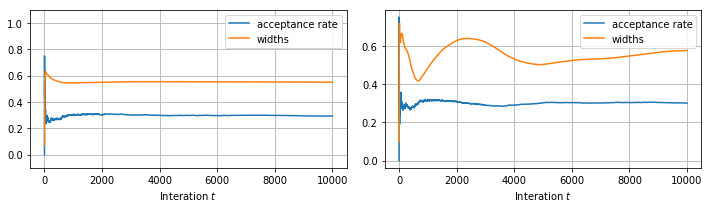

In [23]:
np.random.seed(42)
plt.figure(figsize=(10, 3))
local = proposals.Gaussian(1, cov=0.005)
sampler = StochasticOptimizeUpdate(target, local, target_rate=0.3, mult=.5, t0=1, kappa=.85)

count = 10000
start = [0.4]
state = sampler.init_state(start)
sampler.init_adapt(state)

rate = []
cov = []
for t in range(count):
    state = sampler.next_state(state, t)
    rate.append(sampler.accepted/sampler.generated)
    cov.append(sampler.local_dist.cov)

plt.subplot(121)
plt.plot(rate, label='acceptance rate')
plt.plot(np.sqrt(np.array(cov).flatten()), label='widths')
plt.ylim(-.1, 1.1)
plt.legend()
plt.xlabel('Interation $t$')
plt.grid()


# second
local = proposals.Gaussian(1, cov=0.01)
sampler = StochasticOptimizeUpdate(target, local, target_rate=0.3, mult=.5, t0=1, kappa=.51)

count = 10000
start = [0.4]
state = sampler.init_state(start)
sampler.init_adapt(state)

rate = []
cov = []
for t in range(count):
    state = sampler.next_state(state, t)
    rate.append(sampler.accepted/sampler.generated)
    cov.append(sampler.local_dist.cov)
plt.subplot(122)
plt.plot(rate, label='acceptance rate')
plt.plot(np.sqrt(np.array(cov).flatten()), label='widths')
plt.legend()
# plt.ylim(-.1, 1.1)
plt.xlabel('Interation $t$')
plt.grid()
plt.tight_layout()
plt.savefig('../samples_analysis/img2/mc3adapt.pdf')

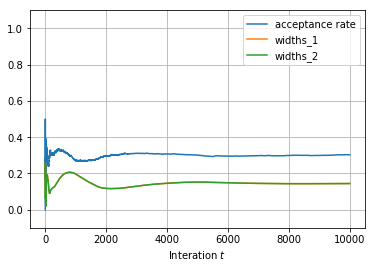

In [29]:
np.random.seed(42)
target = densities.Camel(2)
local = proposals.Gaussian(2, cov=0.005)
sampler = StochasticOptimizeUpdate(target, local, target_rate=0.3, mult=.5, t0=1, kappa=.85)

count = 10000
start = [0.4]*2
state = sampler.init_state(start)
sampler.init_adapt(state)

rate = []
cov = []
for t in range(count):
    state = sampler.next_state(state, t)
    rate.append(sampler.accepted/sampler.generated)
    cov.append(sampler.local_dist.cov)

plt.plot(rate, label='acceptance rate')
plt.plot(np.sqrt(np.array(cov)[:, 0, 0]), label='widths_1')
plt.plot(np.sqrt(np.array(cov)[:, 1, 1]), label='widths_2')
plt.ylim(-.1, 1.1)
plt.legend()
plt.xlabel('Interation $t$')
plt.grid()

# Surrogate

In [80]:
fn = densities.Camel(2)
def target_grad(mgrid, steps):
    grad = fn.pot_gradient(np.array(mgrid).reshape(2, steps * steps).transpose())
    gradx = grad[:, 0].reshape(mgrid[0].shape)
    grady = grad[:, 0].reshape(mgrid[0].shape)
    return gradx, grady

def target_pot(mgrid):
    return -np.ma.log(fn(*mgrid))

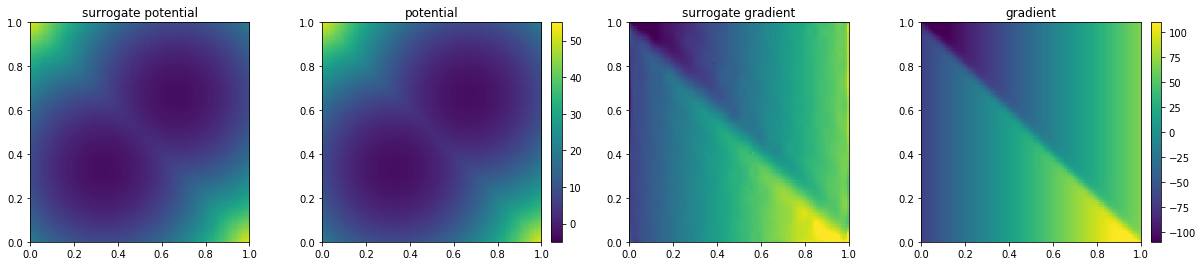

In [187]:
np.random.seed(42)
N = 100000 # training
node_count = 500

basis = surrogate.GaussianBasis(2, (0.001, .5))

# training data
xvals = np.random.random((N, 2))
fvals = fn(*xvals.transpose())

# discard where infty
log_vals = -np.ma.log(fvals)
xvals = xvals[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]

# train
params = basis.extreme_learning_train(xvals, log_vals, node_count)

steps = 100
x = np.linspace(.0001, .9999, steps)
y = np.linspace(.0001, .9999, steps)
mgrid = np.meshgrid(x, y)

plt.figure(figsize=(17, 3.8))
plt.subplot(143)
plt.imshow(basis.eval_gradient_split(*params, *mgrid)[:,:,0], extent=(0, 1, 0, 1), origin='lower', vmin=-110, vmax=110)
plt.title('surrogate gradient')
plt.subplot(141)
plt.imshow(basis.eval_split(*params, *mgrid), extent=(0, 1, 0, 1), origin='lower', vmin=-5, vmax=55)
plt.title('surrogate potential')
plt.subplot(144)
plt.imshow(target_grad(mgrid, steps)[0], extent=(0, 1, 0, 1), origin='lower', vmin=-110, vmax=110)
plt.title('gradient')
plt.colorbar(fraction=0.046, pad=0.04)
plt.subplot(142)
plt.imshow(target_pot(mgrid), extent=(0, 1, 0, 1), origin='lower', vmin=-5, vmax=55)
plt.title('potential')
plt.colorbar(fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('../samples_analysis/img2/surr-qual.pdf')
plt.show()

In [189]:
# POTENTIAL
spot = basis.eval_split(*params, *mgrid)
pot = target_pot(mgrid)
pot_ms = np.mean((pot - spot)**2)

# GRADIENT
# surrogate
sgrad = basis.eval_gradient_split(*params, *mgrid)
sgradx = sgrad[:, :, 0]
sgrady = sgrad[:, :, 1]

# real
gradx, grady = target_grad(mgrid, steps)

grad_ms = np.mean((gradx - sgradx)**2) + np.mean((grady - sgrady)**2)

np.sqrt(pot_ms), np.sqrt(grad_ms)

(0.05091715273519992, 82.73230525389921)

In [139]:
N = 1000 # training
node_count = 100

basis = surrogate.GaussianBasis(2)

# test data
steps = 100
x = np.linspace(.0001, .9999, steps)
y = np.linspace(.0001, .9999, steps)
mgrid = np.meshgrid(x, y)

def do_eval(N, node_count):
    # training data
    xvals = np.random.random((N, 2))
    fvals = fn(*xvals.transpose())

    # discard where infty
    log_vals = -np.ma.log(fvals)
    xvals = xvals[~log_vals.mask]
    log_vals = log_vals[~log_vals.mask]

    # train
    params = basis.extreme_learning_train(xvals, log_vals, node_count)
    
    # POTENTIAL
    spot = basis.eval_split(*params, *mgrid)
    pot = target_pot(mgrid)
    pot_ms = np.mean((pot - spot)**2)
    
    # GRADIENT
    # surrogate
    sgrad = basis.eval_gradient_split(*params, *mgrid)
    sgradx = sgrad[:, :, 0]
    sgrady = sgrad[:, :, 1]
    
    # real
    gradx, grady = target_grad(mgrid, steps)
    
    grad_ms = np.mean((gradx - sgradx)**2) + np.mean((grady - sgrady)**2)
    
    return pot_ms, grad_ms

def pool_interface(pars):
    np.random.seed()
    return do_eval(*pars)

def get_rms(Ns, node_count, repeats):
    pot_rms = []
    pot_rms_var = []
    grad_rms = []
    grad_rms_var = []
    for N in Ns:
        grad_ms = np.empty(repeats)
        pot_ms = np.empty(repeats)
        with Pool() as pool:
            res = pool.map(pool_interface, [(N, node_count)]*repeats)
        for i in range(repeats):
            pot_ms[i], grad_ms[i] = res[i] #do_eval(N, node_count)
        pot_rms.append(np.mean(np.sqrt(pot_ms)))
        pot_rms_var.append(np.var(np.sqrt(pot_ms)))   
        grad_rms.append(np.mean(np.sqrt(grad_ms)))
        grad_rms_var.append(np.var(np.sqrt(grad_ms)))
    return pot_rms, grad_rms, pot_rms_var, grad_rms_var

In [153]:
Ns500 = np.arange(250, 2501, 100)
nodes500 = get_rms(Ns500, 500, 20)

In [154]:
Ns100 = Ns500 - 50
nodes100 = get_rms(Ns100, 100, 20)

In [130]:
# Ns200 = np.arange(250, 1501, 100)
# nodes200 = get_rms(Ns200, 200, 20)

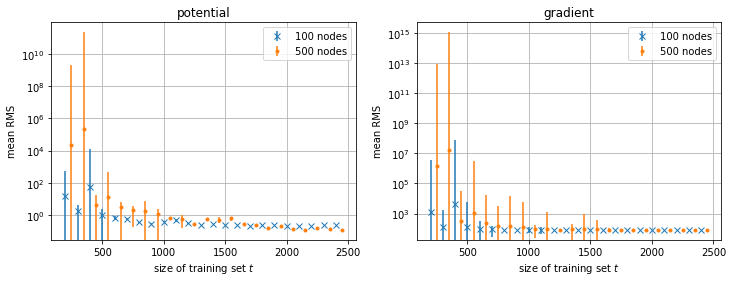

In [198]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.errorbar(Ns100, nodes100[0], fmt='x', yerr=nodes100[2], capsize=0, label='100 nodes')
# plt.errorbar(Ns200, nodes200[0], fmt='.--', yerr=nodes200[2], capsize=5, label='200 nodes')
plt.errorbar(Ns500, nodes500[0], fmt='.', yerr=nodes500[2], capsize=0, label='500 nodes')
plt.gca().set_yscale("log", nonposy='clip')
plt.grid(which='major')
plt.title('potential')
plt.ylabel('mean RMS')
plt.xlabel('size of training set $t$')
plt.legend()

plt.subplot(122)
plt.errorbar(Ns100, nodes100[1], fmt='x', yerr=nodes100[3], capsize=0, label='100 nodes')
# plt.errorbar(Ns200, nodes200[1], fmt='.--', yerr=nodes200[3], capsize=5, label='200 nodes')
plt.errorbar(Ns500, nodes500[1], fmt='.', yerr=nodes500[3], capsize=0, label='500 nodes')
plt.title('gradient')
plt.gca().set_yscale("log", nonposy='clip')
plt.xlabel('size of training set $t$')
plt.ylabel('mean RMS')
plt.grid(which='major')

plt.savefig('../samples_analysis/img2/surr-quan.pdf')
plt.legend()

# Physical example

In [2]:
# PlainMC(8)(densities.ee_qq(100.), 1000).integral
sdf = densities.ee_qq(100.)

In [66]:
sdf.pdf((np.random.rand(8)-1.5)*1000)

array([42.04950331])

In [67]:
e_cm = 100.
mapping = phase_space.RamboOnDiet(e_cm, 2)
target = phase_space.MappedDensity(densities.ee_qq(e_cm), mapping)

In [68]:
int_sample = PlainMC(2)(target, 100000)
int_sample.integral, int_sample.integral_err

(207.472524362921, 0.2684987928137838)

In [71]:
target.norm = int_sample.integral
sample = sampler.sample(10000, [.5]*2)
target.mean = sample.mean
target.variance = sample.variance

Generated 5000 samples.
Generated 10000 samples.


Generated 5000 samples.
Generated 10000 samples.


data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
10000,[0.59923143 0.49398977],[0.09043637 0.08316995],"1.716, p=4.874e-06, N=110",None,0.783700


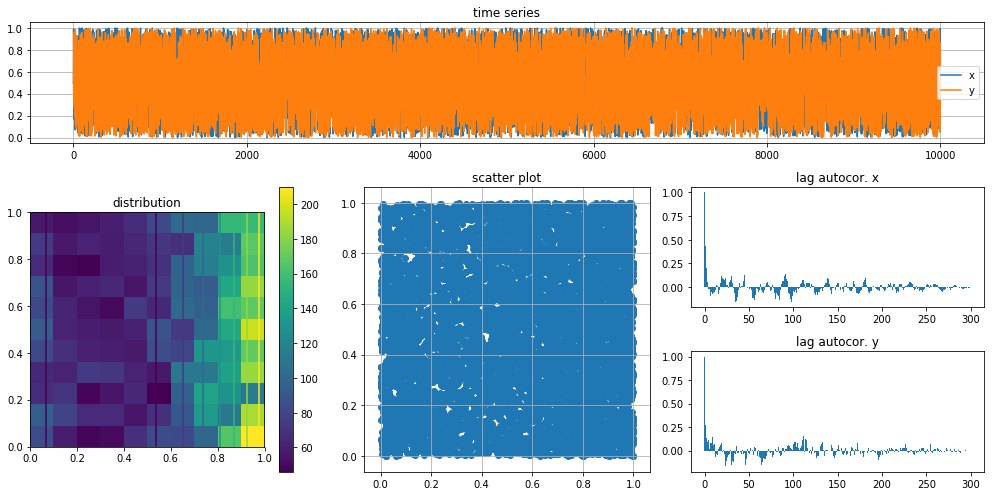

In [70]:
proposal = densities.RamboOnDiet(2, e_cm)
sampler = DefaultMetropolis(2, target)
sample = sampler.sample(10000, [.5]*2)
sample

## Surrogate

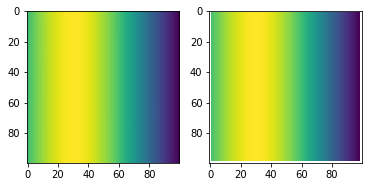

In [72]:
nodes = 50
nlearn = 1000
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
mgrid = np.meshgrid(x, y)

xvals = np.random.random((nlearn, 2))
fvals = target.pdf(xvals)

# surrogate
basis = surrogate.extreme_learning.GaussianBasis(2)
log_vals = -np.ma.log(fvals)
xvals = xvals[~log_vals.mask]
log_vals = log_vals[~log_vals.mask]
# train
params = basis.extreme_learning_train(xvals, log_vals, nodes)

# surrogate gradient
def surrogate_gradient(xs):
    return basis.eval_gradient(*params, xs)
target.pot_gradient = surrogate_gradient
util.count_calls(target, 'pot_gradient')

plt.subplot(121)
plt.imshow(basis.eval_split(*params, *mgrid))
plt.subplot(122)
plt.imshow(-np.ma.log(target(*mgrid)))
plt.show()

In [13]:
# POTENTIAL
def target_pot(mgrid):
    return -np.ma.log(target(*mgrid))

spot = basis.eval_split(*params, *mgrid)
pot = target_pot(mgrid)
pot_ms = np.mean((pot - spot)**2)

np.sqrt(pot_ms)

0.00037531216088365643

0.000000 * 0.502730 = 0.000000 ; 0.156019 > 0.000000
0.000000 * 1.072928 = 0.000000 ; 0.181825 > 0.000000
0.000000 * 0.655728 = 0.000000 ; 0.611853 > 0.000000
0.000000 * 0.228138 = 0.000000 ; 0.199674 > 0.000000
0.000000 * 0.000964 = 0.000000 ; 0.046450 > 0.000000
0.000000 * 0.592778 = 0.000000 ; 0.097672 > 0.000000


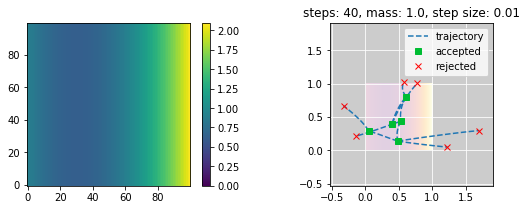

In [35]:
x = np.linspace(0.0001, .9999, 100)
y = np.linspace(0.0001, .9999, 100) 
mgrid = np.meshgrid(x, y)
prob = target(*mgrid)

plt.figure(figsize=(15, 3))
plt.subplot(131)
plt.imshow(prob, origin='lower', vmin=0)
plt.colorbar()

np.random.seed(42)
plt.subplot(132)
plot_hmc_traj(target, mass=1., step_size=0.01, steps=40)
plt.tight_layout()
plt.savefig('../samples_analysis/img2/ee_qq.pdf')

Generated 5000 samples.
Generated 10000 samples.


data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
10000,[0.59288042 0.47177034],[0.08998119 0.08478801],"5.435, p=1.423e-61, N=100",[ 923.26471091 1141.68476869],0.357100


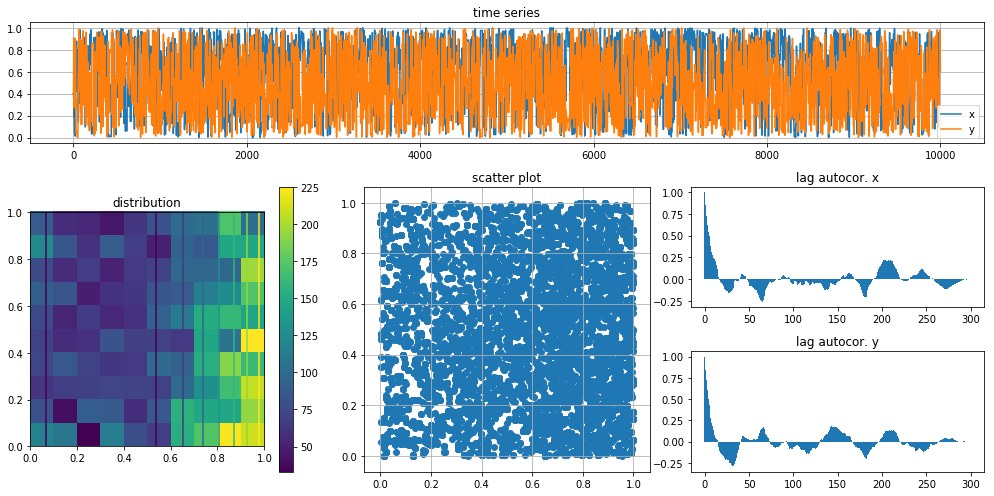

In [24]:
mom = densities.Gaussian(2, cov=1.0)
sampler = hamiltonian.HamiltonianUpdate(target, mom, 40, 0.01)
sampler.sample(10000, [.4]*2)

In [34]:
sampler = hamiltonian.StaticSphericalHMC(target, .01, .01, 40, 40)
samplehmc = sampler.sample(10000, [0.4]*2)

Generated 5000 samples.
Generated 10000 samples.


data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
10000,[0.58787044 0.49893749],[0.09031882 0.08208939],"2.77, p=4.93e-20, N=110",[10000. 10000.],0.999300


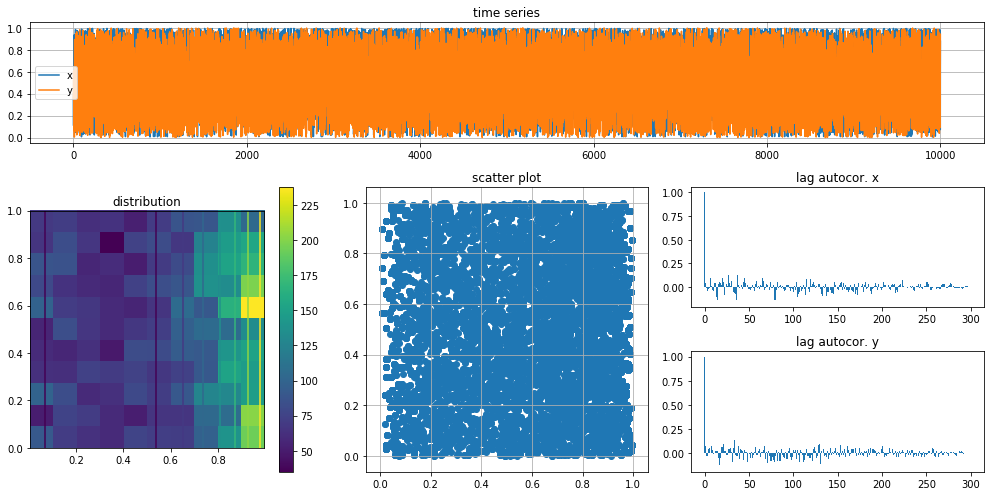

In [36]:
samplehmc

In [82]:
sampler = hamiltonian.SphericalNUTS(target, lambda t: t<1000, Emax=100)
samplenuts = sampler.sample(10000, [0.4]*2)

Generated 5000 samples.
Generated 10000 samples.


data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
10000,[0.6192247 0.50346281],[0.08249285 0.0822501 ],"4.671, p=4.566e-58, N=121",[10000. 10000.],0.922300


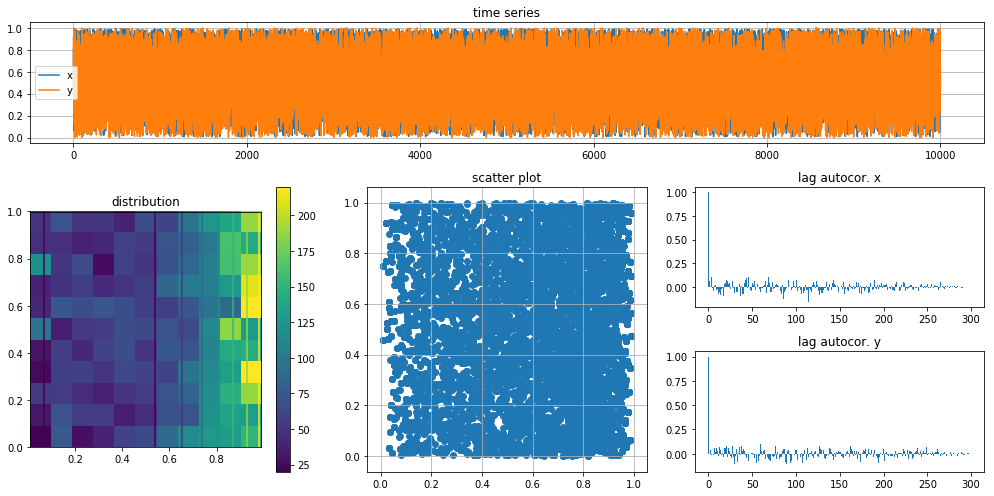

In [81]:
samplenuts

data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
10000,[0.62904832 0.51432934],[0.0858854 0.08315268],"5.1, p=5.259e-67, N=121",[10000. 10000.],0.925200


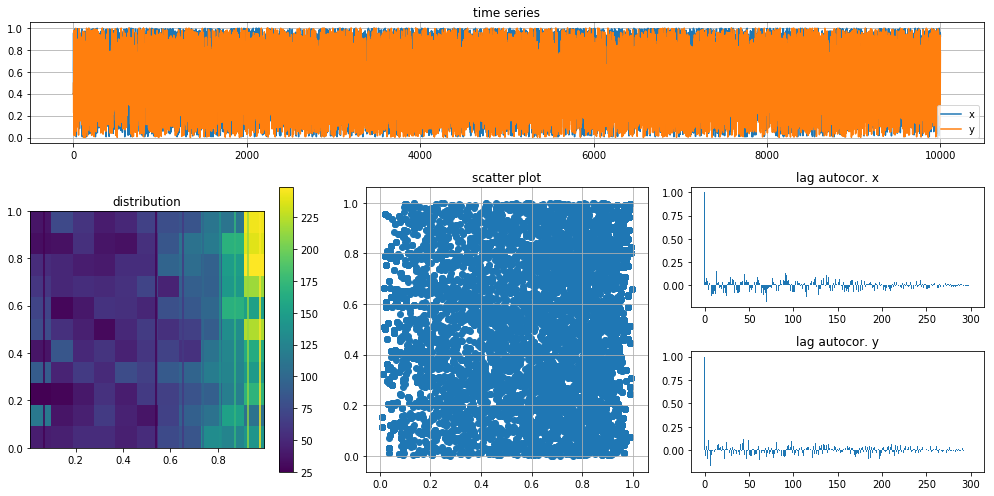

In [76]:
samplenuts

In [83]:
sampler = hamiltonian.NUTSUpdate(target, densities.Gaussian(2, cov=1.), lambda t: t<1000, Emax=100)
samplesimplenuts = sampler.sample(10000, [0.4]*2)

/home/mathis/Dev/hep-monte-carlo/src/hepmc/surrogate/extreme_learning.py:204: RuntimeWarning: overflow encountered in square
  inputs = inputs ** 2 / 2
/home/mathis/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:2286: RuntimeWarning: overflow encountered in multiply
  s = (x.conj() * x).real
/home/mathis/Dev/hep-monte-carlo/src/hepmc/hamiltonian/simulation.py:40: RuntimeWarning: overflow encountered in multiply
  q += self.step_size * self.kin_gradient(p)[0]
/home/mathis/Dev/hep-monte-carlo/src/hepmc/hamiltonian/nuts.py:58: RuntimeWarning: invalid value encountered in true_divide
  dE = self.target_density.pdf(q_prime)/self.p_dist.pdf(p_prime)
/home/mathis/Dev/hep-monte-carlo/src/hepmc/hamiltonian/nuts.py:83: RuntimeWarning: invalid value encountered in true_divide
  if np.random.uniform() < n_2prime/(n_prime + n_2prime):


Generated 5000 samples.
Generated 10000 samples.


In [84]:
util.bin_wise_chi2(samplesimplenuts, [20, 20], int_steps=1000)

(82.99893021389651, 0.0, 167)

0.000000 * 0.502730 = 0.000000 ; 0.156019 > 0.000000
0.000000 * 1.072928 = 0.000000 ; 0.181825 > 0.000000
0.000000 * 0.655728 = 0.000000 ; 0.611853 > 0.000000
0.000000 * 0.228138 = 0.000000 ; 0.199674 > 0.000000
0.000000 * 0.000964 = 0.000000 ; 0.046450 > 0.000000
0.000000 * 0.592778 = 0.000000 ; 0.097672 > 0.000000


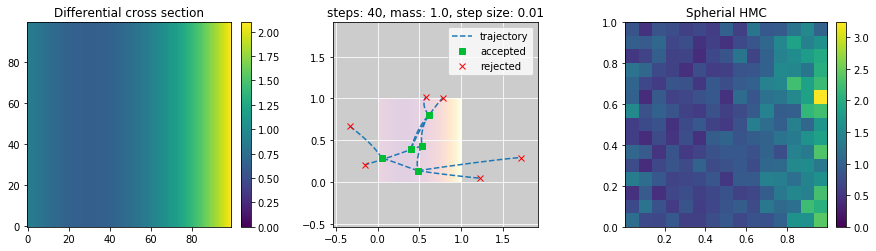

In [59]:
x = np.linspace(0.0001, .9999, 100)
y = np.linspace(0.0001, .9999, 100) 
mgrid = np.meshgrid(x, y)
prob = target(*mgrid)

plt.figure(figsize=(15*.8, 4.5*.8))
plt.subplot(131)
plt.imshow(prob, origin='lower', vmin=0)
plt.colorbar(fraction=0.046, pad=0.04)
plt.title('Differential cross section')

np.random.seed(42)
plt.subplot(132)
plot_hmc_traj(target, mass=1., step_size=0.01, steps=40)
plt.tight_layout()

bins = [15, 15]

ax2 = plt.subplot(133)
ax2.set_title('Spherial HMC')
counts, xedges, yedges, im = ax2.hist2d(*samplehmc.data.transpose(), bins=bins, normed=True, vmin=0)
if target is not None:
    extent = (xedges[0], xedges[-1], yedges[0], yedges[-1])
    x = np.linspace(extent[0], extent[1], max(bins)*10)
    y = np.linspace(extent[2], extent[3], max(bins)*10)
    mgrid = np.meshgrid(x, y)
#     ax2.contour(x, y, target(*mgrid))
plt.colorbar(im, ax=ax2, fraction=0.046, pad=0.04)
ax2.set_aspect('equal')

plt.savefig('../samples_analysis/img2/ee_qq.pdf')
plt.show()

Generated 5000 samples.
Generated 10000 samples.


data (size),mean,variance,bin-wise chi^2,effective sample size,acceptance rate
10000,[0.64377707 0.49445289],[0.08070278 0.07977646],"7.426, p=1.347e-128, N=132",[10000. 10000.],0.999800


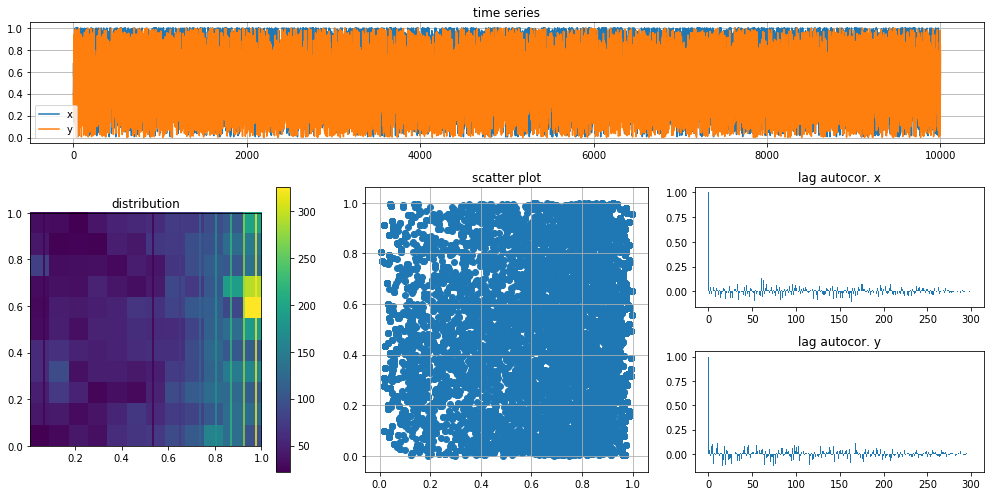

In [33]:
sampler = hamiltonian.StaticSphericalHMC(target, .001, .01, 30, 50)
sampler.sample(10000, [0.4]*2)